In [31]:
import re
import math

def stokes_factor(nu_cm, I_raman, T=300.0):
    # k_B * 300 K ~ 208 cm^-1 (roughly)
    # h nu / (k_B T) ~ nu / (208 cm^-1)
    k_B_T_cm = 208.0 * (T / 300.0)  # scale if T != 300

    x = nu_cm / k_B_T_cm  # dimensionless ratio h nu / (k_B T)
    if x < 1e-6:
        # avoid numerical blow-up if nu_cm is extremely small
        # in practice, you won't usually have that small, but just in case
        n_bar = 1.0 / x  # approximate expansion
    else:
        n_bar = 1.0 / (math.exp(x) - 1.0)  # Bose-Einstein factor
    laser_factor = math.pow((15600.0-nu_cm)/15600.0, 4)
    return ((n_bar + 1.0) / nu_cm) * I_raman * laser_factor


def extract_frequencies(file_path):
    frequencies = []
    intensities = []
    ir_freq = []
    ir_intes = []
    activities = []
    irreps = []
    in_table = False
    
    with open(file_path, 'r') as file:
        for line in file:
            # Detect the start of a new vibrational frequencies table
            if "Vibrational Frequencies" in line:
                in_table = True
                continue
            
            # Detect the end of the table
            if in_table and "." * 70 in line:
                in_table = False
            
            if in_table:
                parts = line.split()
                if len(parts) == 9:
                    if parts[7] == 'Y':
                        freq = float(parts[2])
                        activity = float(parts[6])
                        intensity = stokes_factor(freq, activity)
                        frequencies.append(freq)
                        intensities.append(intensity)
                        activities.append(activity)
                        irreps.append(parts[3])
                    if parts[5] == 'Y':
                        ir_freq.append(float(parts[2]))
                        ir_intes.append(float(parts[4]))
    return frequencies, intensities, activities, irreps, ir_freq, ir_intes
import os 
filename = 'input\dfpt_freq.txt'
frequencies, intensities, activities, irreps, ir_freq, ir_intens = extract_frequencies(filename)

print("Extracted Frequencies:", frequencies)
print("Extracted Intensities:", intensities)

print("Extracted IR intensities:", ir_freq)
print("Extracted IR intensities:", ir_intens)
print("Irreps: ", irreps)

Extracted Frequencies: [45.215501, 45.215501, 45.215501, 52.597421, 52.597421, 52.597421, 56.120118, 56.120118, 56.120118, 61.640431, 67.918822, 67.918822, 84.692793, 84.692793, 84.692793, 85.207996, 85.207996, 86.271004, 95.327714, 95.327714, 95.327714, 103.985153, 103.985153, 103.985153, 105.84268, 105.84268, 105.84268, 123.242607, 123.242607, 123.902749, 123.902749, 123.902749, 133.801939, 133.801939, 133.801939, 143.461409, 164.538659, 171.437488, 171.437488, 171.437488, 187.32576, 187.32576, 187.32576, 212.413334, 212.413334, 212.413334, 226.2259, 226.2259, 226.2259, 243.241991, 243.241991, 278.418221, 284.712247, 284.712247, 284.712247, 313.756159, 313.756159, 313.756159, 330.645604, 330.645604, 336.066625, 358.626798, 358.626798, 358.626798, 365.369386, 365.369386, 371.540517, 371.540517, 371.540517, 447.266608, 447.266608, 447.266608, 468.640152, 468.640152, 468.640152, 477.118887, 477.118887, 496.164308, 496.164308, 496.164308, 530.735009, 530.735009, 530.735009, 556.550485, 5

[45.215501, 45.215501, 45.215501, 52.597421, 52.597421, 52.597421, 56.120118, 56.120118, 56.120118, 61.640431, 67.918822, 67.918822, 84.692793, 84.692793, 84.692793, 85.207996, 85.207996, 86.271004, 95.327714, 95.327714, 95.327714, 103.985153, 103.985153, 103.985153, 105.84268, 105.84268, 105.84268, 123.242607, 123.242607, 123.902749, 123.902749, 123.902749, 133.801939, 133.801939, 133.801939, 143.461409, 164.538659, 171.437488, 171.437488, 171.437488, 187.32576, 187.32576, 187.32576, 212.413334, 212.413334, 212.413334, 226.2259, 226.2259, 226.2259, 243.241991, 243.241991, 278.418221, 284.712247, 284.712247, 284.712247, 313.756159, 313.756159, 313.756159, 330.645604, 330.645604, 336.066625, 358.626798, 358.626798, 358.626798, 365.369386, 365.369386, 371.540517, 371.540517, 371.540517, 447.266608, 447.266608, 447.266608, 468.640152, 468.640152, 468.640152, 477.118887, 477.118887, 496.164308, 496.164308, 496.164308, 530.735009, 530.735009, 530.735009, 556.550485, 561.701883, 561.701883, 

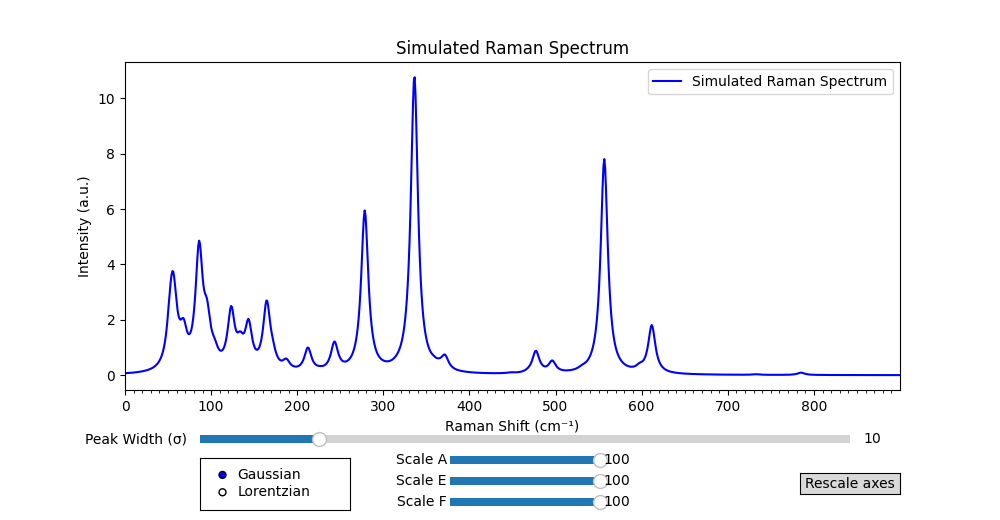

In [30]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
from matplotlib.widgets import RadioButtons
import math 

def gaussian(x, x0, I0, sigma):
    return I0 * np.exp(-((x - x0) ** 2) / (sigma ** 2))

def lorentzian(x, x0, I0, gamma):
    return I0 / (1 + ((x - x0) / (gamma*0.5)) ** 2)

# Generate Raman spectrum
def generate_raman_spectrum(peaks, intensities, sigma=5, scalea=100, scalee=100, scalef=100, x_range=(0, 900), num_points=900):
    max_intensity = max(intensities)
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.zeros_like(x)

    for x0, I0, irr in zip(peaks, intensities, irreps):
        scale = 100 
        if irr == 'a':
            scale = scalef
        elif irr == 'b':
            scale = scalea
        elif irr == 'c':
            scale = scalee
        if radio.value_selected == 'Gaussian':
            #y += gaussian(x, x0, (I0)*(scale/100.0), sigma/2 + sigma*(I0/(2*max_intensity)))
            y += gaussian(x, x0, (I0)*(scale/100.0), sigma)
        else:
            y += lorentzian(x, x0, (I0)*(scale/100.0), sigma)
    
    return x, y

def update_plot(val):
    sigma = sigma_slider.val  
    x_updated, y_updated = generate_raman_spectrum(frequencies, intensities, sigma=sigma, scalea=ascale_slider.val,
                                                    scalee= bscale_slider.val, scalef=cscale_slider.val)

    line.set_ydata(y_updated)
    fig.canvas.draw_idle()  
    
def rescale():
    ax.set_ylim(min(line.get_ydata), max(line.get_ydata)+50)
    ax.relim()  
    ax.autoscale_view()  
    #fig.autoscale()
    
sigma_init = 10
# Generate and plot the spectrum
print(frequencies)
x, y = generate_raman_spectrum(frequencies, intensities, sigma_init)
fig,ax = plt.subplots(figsize=(1000 / 100, 520 / 100), dpi=100)
plt.subplots_adjust(bottom=0.25)
plt.xlim(0, 900)
line, = plt.plot(x, y, label="Simulated Raman Spectrum", color='b')

#plt.scatter(frequencies, intensities, color='r', label="Peak Positions")
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Simulated Raman Spectrum")
major_ticks = np.arange(0, 900, step=100)
minor_ticks = np.arange(0, 900, step=10)
plt.xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
plt.legend()

ax_sigma = plt.axes([0.2, 0.14, 0.65, 0.03])  
ax_scale = plt.axes([0.45, 0.10, 0.15, 0.03])  
bx_scale = plt.axes([0.45, 0.06, 0.15, 0.03])  
cx_scale = plt.axes([0.45, 0.02, 0.15, 0.03])  

sigma_slider = Slider(ax_sigma, "Peak Width (σ)", 1, 50, valinit=sigma_init)
ascale_slider = Slider(ax_scale, "Scale A", 0, 100, valinit=100)
bscale_slider = Slider(bx_scale, "Scale E", 0, 100, valinit=100)
cscale_slider = Slider(cx_scale, "Scale F", 0, 100, valinit=100)
rax = plt.axes([0.2, 0.02, 0.15, 0.1])  # [left, bottom, width, height] in figure coordinates
radio = RadioButtons(rax, ('Gaussian', 'Lorentzian'), active=0)  # Default: Gaussian

sigma_slider.on_changed(update_plot)
ascale_slider.on_changed(update_plot)
bscale_slider.on_changed(update_plot)
cscale_slider.on_changed(update_plot)
radio.on_clicked(update_plot)
ax_button = plt.axes([0.8, 0.05, 0.1, 0.04])  
button = Button(ax_button, 'Rescale axes')

button.on_clicked(rescale)
plt.show()

[45.215501, 45.215501, 45.215501, 52.597421, 52.597421, 52.597421, 56.120118, 56.120118, 56.120118, 61.640431, 67.918822, 67.918822, 84.692793, 84.692793, 84.692793, 85.207996, 85.207996, 86.271004, 95.327714, 95.327714, 95.327714, 103.985153, 103.985153, 103.985153, 105.84268, 105.84268, 105.84268, 123.242607, 123.242607, 123.902749, 123.902749, 123.902749, 133.801939, 133.801939, 133.801939, 143.461409, 164.538659, 171.437488, 171.437488, 171.437488, 187.32576, 187.32576, 187.32576, 212.413334, 212.413334, 212.413334, 226.2259, 226.2259, 226.2259, 243.241991, 243.241991, 278.418221, 284.712247, 284.712247, 284.712247, 313.756159, 313.756159, 313.756159, 330.645604, 330.645604, 336.066625, 358.626798, 358.626798, 358.626798, 365.369386, 365.369386, 371.540517, 371.540517, 371.540517, 447.266608, 447.266608, 447.266608, 468.640152, 468.640152, 468.640152, 477.118887, 477.118887, 496.164308, 496.164308, 496.164308, 530.735009, 530.735009, 530.735009, 556.550485, 561.701883, 561.701883, 

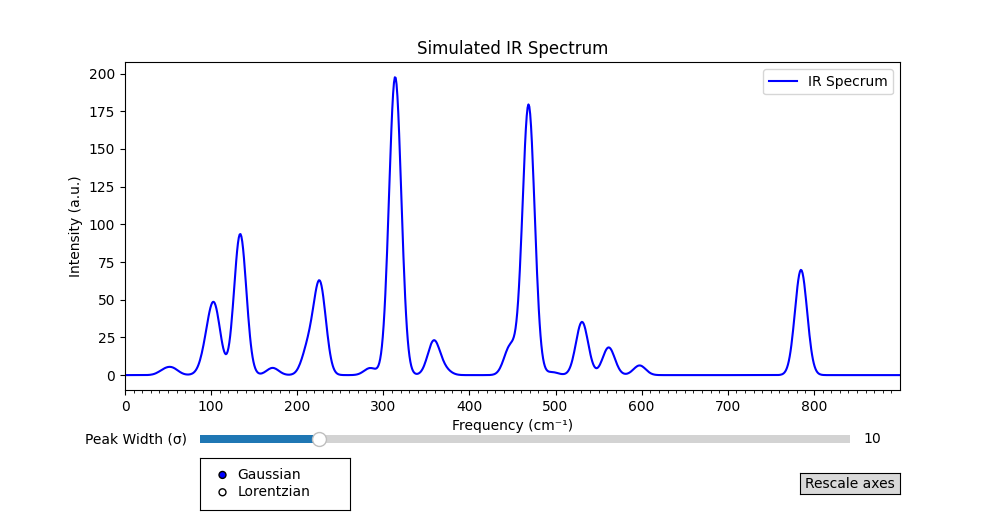

In [33]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
from matplotlib.widgets import RadioButtons
import math 

def gaussian(x, x0, I0, sigma):
    return I0 * np.exp(-((x - x0) ** 2) / (sigma ** 2))

def lorentzian(x, x0, I0, gamma):
    return I0 / (1 + ((x - x0) / (gamma*0.5)) ** 2)

# Generate Raman spectrum
def generate_ir_spectrum(peaks, intensities, sigma=5, x_range=(0, 900), num_points=900):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.zeros_like(x)

    for x0, I0, irr in zip(peaks, intensities, irreps):
        
        if radio.value_selected == 'Gaussian':
            #y += gaussian(x, x0, (I0)*(scale/100.0), sigma/2 + sigma*(I0/(2*max_intensity)))
            y += gaussian(x, x0, (I0), sigma)
        else:
            y += lorentzian(x, x0, (I0), sigma)
    
    return x, y

def update_plot(val):
    sigma = sigma_slider.val  
    x_updated, y_updated = generate_ir_spectrum(ir_freq, ir_intens, sigma=sigma)

    line.set_ydata(y_updated)
    fig.canvas.draw_idle()  
    
def rescale():
    ax.set_ylim(min(line.get_ydata), max(line.get_ydata)+50)
    ax.relim()  
    ax.autoscale_view()  
    #fig.autoscale()
    
sigma_init = 10
# Generate and plot the spectrum
print(frequencies)
x, y = generate_ir_spectrum(ir_freq, ir_intens, sigma_init)
fig,ax = plt.subplots(figsize=(1000 / 100, 520 / 100), dpi=100)
plt.subplots_adjust(bottom=0.25)
plt.xlim(0, 900)
line, = plt.plot(x, y, label="IR Specrum", color='b')

#plt.scatter(frequencies, intensities, color='r', label="Peak Positions")
plt.xlabel("Frequency (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Simulated IR Spectrum")
major_ticks = np.arange(0, 900, step=100)
minor_ticks = np.arange(0, 900, step=10)
plt.xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
plt.legend()

ax_sigma = plt.axes([0.2, 0.14, 0.65, 0.03])  

sigma_slider = Slider(ax_sigma, "Peak Width (σ)", 1, 50, valinit=sigma_init)
rax = plt.axes([0.2, 0.02, 0.15, 0.1])  # [left, bottom, width, height] in figure coordinates
radio = RadioButtons(rax, ('Gaussian', 'Lorentzian'), active=0)  # Default: Gaussian

sigma_slider.on_changed(update_plot)
radio.on_clicked(update_plot)
ax_button = plt.axes([0.8, 0.05, 0.1, 0.04])  
button = Button(ax_button, 'Rescale axes')

button.on_clicked(rescale)
plt.show()